In [26]:
import torch
from torch.autograd import Variable
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import ipdb
import sys, glob
import numpy as np
from PIL import Image
import time
import os
from robustness_lib.robustness import model_utils, datasets
from user_constants import DATA_PATH_DICT
from robustness_lib.robustness.tools.vis_tools import show_image_column

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print('Imports done')
%matplotlib inline

import matplotlib as mpl

Imports done


In [27]:
dpi = 250
mpl.rcParams['figure.dpi']= dpi
mpl.rc("savefig", dpi=dpi)

In [28]:
# Constants
DATA = 'ImageNet'  # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 500
# BATCH_SIZE = 2
NUM_WORKERS = 8
NOISE_SCALE = 20

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224  # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048  # Size of representation vector (fixed for model)

In [29]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE,
                                      data_aug=False, only_val=True)
data_iterator = enumerate(test_loader)
print('Data iterator created')

==> Preparing dataset imagenet..
Data iterator created


In [30]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}
model_kwargs['state_dict_path'] = 'model'
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
for p in model.parameters():
    p.requires_grad = False
print('Model created')

=> loading checkpoint './models/ImageNet.pt'
=> loaded checkpoint './models/ImageNet.pt' (epoch 105)
Model created


In [31]:
_, (im, targ) = next(data_iterator)
targ = targ.cpu().numpy()
log, _ = model(im)
probs = F.softmax(log, dim=1).cpu()
labels = torch.argmax(probs, dim=-1).numpy()

# print(f'Pred labels are: {labels}')
# print(f'Orig labels are: {targ}')

In [32]:
top_probs, top_idxs = torch.topk(probs, 5, dim=-1)
top_probs = top_probs.cpu().numpy()
top_idxs = top_idxs.cpu().numpy()
# top_idxs, top_probs

In [33]:
def imagenet_label_mappings():
    with open("imagenet_label_mapping") as f:
        image_label_mapping = {int(x.split(":")[0]): x.split(":")[1].strip()
                               for x in f.readlines() if len(x.strip()) > 0}

        return image_label_mapping
im_label_map = imagenet_label_mappings()

In [34]:
orig_img = im.cpu().detach().numpy()
orig_img = orig_img[:10]
orig_img = np.rollaxis(orig_img, 1, 4)
im_count = orig_img.shape[0]    
print(im_count)

10


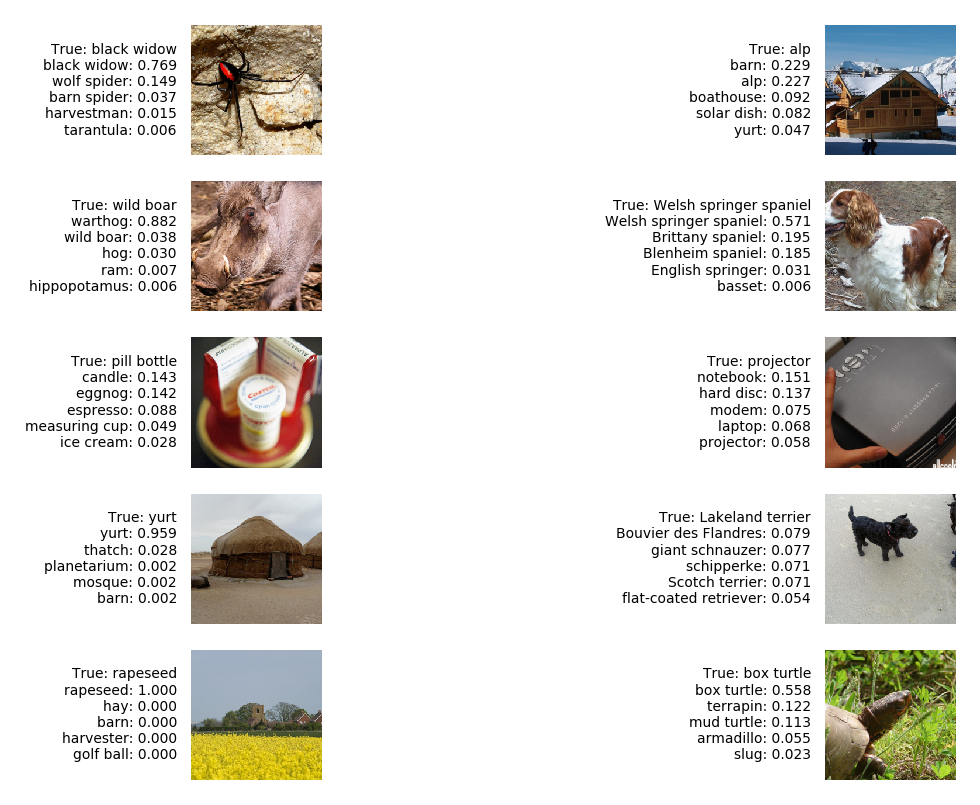

In [35]:
aa = 0
fig, ax = plt.subplots(im_count//2, 2) #, sharex='col', sharey='row')
for i in range(im_count//2):    
    for j in range(2):
        ax[i, j].imshow(orig_img[aa])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)
#         ipdb.set_trace()
        label = [f'{im_label_map[top_idxs[aa, ii]]}: {top_probs[aa, ii]:.3f}' for ii in range(5)]
#         ipdb.set_trace()
        ax[i, j].set_ylabel(f'True: {im_label_map[targ[aa]]}\n'+'\n'.join(label), fontsize=4, rotation=0, 
                            verticalalignment='center', horizontalalignment='right')
        aa += 1
      

In [36]:
correct = 0
im_count = 0
for idx, (im, targ) in data_iterator:
    im_count += im.shape[0]
    targ = targ.cpu().numpy()
    log, _ = model(im) 
    probs = F.softmax(log, dim=1).cpu()

    labels = torch.argmax(probs, dim=-1).numpy()
#     ipdb.set_trace()
    correct += np.size(np.where((targ - labels) == 0))
    
    if idx%20 == 0:
        print(f'Batch is: {idx}')
        print(f'Correct images are {correct}/{im_count}')

print(f'Final results - Correct images are {correct}/{im_count}')


Batch is: 20
Correct images are 5696/10000
Batch is: 40
Correct images are 11514/20000
Batch is: 60
Correct images are 17347/30000
Batch is: 80
Correct images are 23163/40000
Final results - Correct images are 28648/49500


In [37]:
print(f'Percentage of correct images are {correct*100/im_count}%')

Percentage of correct images are 57.87474747474747%
